In [15]:
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
from pystac_client import Client
from pystac_client.exceptions import APIError
import requests

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import contextily as ctx
from shapely.geometry import shape


class EnMAPDownloader:
    def __init__(self, gdf: gpd.GeoDataFrame, limit=10, simplify_tolerance=0.0001):
        """
        Parameters:
        - gdf: GeoDataFrame with plot polygons and 'plot_id' column
        - limit: max number of STAC items to fetch per plot
        - simplify_tolerance: simplify tolerance in degrees to reduce geometry complexity
        """
        self.gdf = gdf.to_crs("EPSG:4326")
        self.limit = limit
        self.simplify_tolerance = simplify_tolerance
        self.catalog = Client.open("https://geoservice.dlr.de/eoc/ogc/stac/v1/")
        self.collection = "ENMAP_HSI_L2A"
        self.results = {}

    def _get_items_with_retry(self, search, retries=3, delay=2):
        for attempt in range(retries):
            try:
                return list(search.get_items())
            except APIError as e:
                print(f"[Retry {attempt+1}] APIError: {e}")
                if attempt < retries - 1:
                    time.sleep(delay * (attempt + 1))
                else:
                    raise

    def query_images(self):
        print("Starting EnMAP query for all plots...")
        for idx, row in self.gdf.iterrows():
            plot_id = row["plot_id"]
            try:
                geom = mapping(row["geometry"].simplify(self.simplify_tolerance, preserve_topology=True))
                search = self.catalog.search(
                    collections=[self.collection],
                    intersects=geom,
                    limit=self.limit
                )
                items = self._get_items_with_retry(search)
                self.results[plot_id] = items
                print(f"✅ {plot_id}: found {len(items)} items")
            except Exception as e:
                print(f"❌ {plot_id}: Error - {e}")

    def inspect_metadata(self, plot_id):
        """Return list of STAC metadata dicts for a given plot ID."""
        return [item.to_dict() for item in self.results.get(plot_id, [])]

    def list_available_assets(self, plot_id):
        """List all available asset keys for a given plot ID."""
        items = self.results.get(plot_id, [])
        if not items:
            return []
        return list(items[0].assets.keys())

    def filter_results_by_properties(self, plot_id, filters):
        """
        Filters items for a plot by property conditions.

        Parameters:
        - plot_id: str, the plot ID.
        - filters: dict, e.g., {"eo:cloud_cover": lambda v: float(v) < 10}

        Returns:
        - List of filtered STAC Items.
        """
        items = self.results.get(plot_id, [])
        if not items:
            return []

        def item_passes(item):
            props = item.properties
            for key, test_func in filters.items():
                if key not in props:
                    return False
                try:
                    if not test_func(props[key]):
                        return False
                except:
                    return False
            return True

        return [item for item in items if item_passes(item)]

    def summarize_metadata(self, plot_ids=None):
        """
        Generate a summary DataFrame of EnMAP metadata for selected or all plots.

        Parameters:
        - plot_ids: optional list of plot IDs to include

        Returns:
        - pd.DataFrame with columns: plot_id, plot_datetime, item_id, hsi_datetime,
        cloud_cover, tileID, href
        """
        summary = []
        target_plots = plot_ids if plot_ids is not None else self.results.keys()

        for plot_id in target_plots:
            items = self.results.get(plot_id, [])
            # Get plot_datetime from self.gdf
            try:
                plot_row = self.gdf[self.gdf["plot_id"] == plot_id]
                plot_datetime = plot_row.iloc[0]["survey_date"] if not plot_row.empty else None
            except Exception:
                plot_datetime = None

            for item in items:
                props = item.properties
                assets = item.assets
                summary.append({
                    "plot_id": plot_id,
                    "plot_datetime": plot_datetime,
                    "item_id": item.id,
                    "hsi_datetime": props.get("datetime"),
                    "cloud_cover": props.get("eo:cloud_cover"),
                    "tileID": props.get("enmap:tileID"),
                    "href": assets["image"].href if "image" in assets else "N/A"
                })

        return pd.DataFrame(summary)

    def visualize_plot_and_enmap_bounds(self, plot_id, filtered_items=None, basemap=True):
        """
        Plot the OFO plot and overlapping EnMAP scenes with optional basemap.

        Parameters:
        - plot_id: str
        - filtered_items: optional list of filtered STAC items
        - basemap: bool, whether to include a basemap from contextily
        """
        # Select the plot
        plot_geom = self.gdf[self.gdf["plot_id"] == plot_id]
        if plot_geom.empty:
            print(f"No plot found with ID '{plot_id}'")
            return

        # Use filtered or unfiltered EnMAP scenes
        items = filtered_items if filtered_items is not None else self.results.get(plot_id, [])
        if not items:
            print(f"No EnMAP scenes found for plot {plot_id}")
            return

        # Convert STAC geometries to GeoDataFrame
        enmap_polys = [shape(item.geometry) for item in items]
        enmap_gdf = gpd.GeoDataFrame(geometry=enmap_polys, crs="EPSG:4326")

        # Reproject to EPSG:3857 for basemap compatibility
        plot_geom_3857 = plot_geom.to_crs(epsg=3857)
        enmap_gdf_3857 = enmap_gdf.to_crs(epsg=3857)

        # Plotting
        fig, ax = plt.subplots(figsize=(10, 8))
        plot_geom_3857.plot(ax=ax, edgecolor='green', facecolor='none', linewidth=2)
        enmap_gdf_3857.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

        # Add basemap
        if basemap:
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=plot_geom_3857.crs)

        # Custom legend
        plot_patch = mpatches.Patch(facecolor='none', edgecolor='green', label='OFO Plot', linewidth=2)
        scene_patch = mpatches.Patch(facecolor='none', edgecolor='red', label='EnMAP Scenes', linewidth=1)
        ax.legend(handles=[plot_patch, scene_patch])

        plt.title(f"Plot '{plot_id}' and Overlapping EnMAP Scene Boundaries")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True)
        plt.show()


    def download_item_product(self, plot_id, item, asset_key="image", out_dir="./downloads", username=None, password=None, headless=True, overwrite=False):
        from selenium import webdriver
        from selenium.webdriver.common.by import By
        from selenium.webdriver.common.keys import Keys
        from selenium.webdriver.chrome.service import Service
        from selenium.webdriver.chrome.options import Options
        from selenium.webdriver.support.ui import WebDriverWait
        from selenium.webdriver.support import expected_conditions as EC
        from webdriver_manager.chrome import ChromeDriverManager
        import glob

        if username is None or password is None:
            print("❌ Username and password must be provided.")
            return

        # Create plot-specific subdir
        plot_dir = os.path.join(out_dir, plot_id)
        os.makedirs(plot_dir, exist_ok=True)

        try:
            asset = item.assets[asset_key]
            href = asset.href
            filename = f"{plot_id}_{item.id}_{asset_key}.tif"
            final_path = os.path.join(plot_dir, filename)

            if os.path.exists(final_path) and not overwrite:
                print(f"⏭️ File exists, skipping: {final_path}")
                return

            crdownload_path = final_path + ".crdownload"

            # === Set Chrome options ===
            chrome_options = Options()
            if headless:
                chrome_options.add_argument("--headless=new")
            chrome_options.add_experimental_option("prefs", {
                "download.default_directory": os.path.abspath(plot_dir),
                "download.prompt_for_download": False,
                "safebrowsing.enabled": True
            })

            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

            try:
                login_url = f"https://sso.eoc.dlr.de/eoc/auth/login?service={href}"
                driver.get(login_url)

                WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, "username")))
                driver.find_element(By.ID, "username").send_keys(username)
                password_input = driver.find_element(By.ID, "password")
                password_input.send_keys(password)
                password_input.send_keys(Keys.RETURN)

                print(f"⬇️ Downloading {filename}...")

                # Wait for download to start
                while not os.path.exists(final_path) and not glob.glob(os.path.join(plot_dir, "*.crdownload")):
                    time.sleep(1)

                # Wait for download to complete
                while glob.glob(os.path.join(plot_dir, "*.crdownload")):
                    time.sleep(2)

                print(f"✅ Download complete: {final_path}")

            finally:
                driver.quit()
                print("✅ Selenium driver closed.")

        except Exception as e:
            print(f"❌ Download error for {plot_id}, item {item.id}: {e}")

    def batch_download(
        self,
        plot_ids=None,
        asset_key="image",
        out_dir="./downloads",
        username=None,
        password=None,
        headless=True,
        filters=None,
        max_per_plot=None,
        overwrite=False
    ):
        """
        Batch download EnMAP assets with filtering and smart organization.

        Parameters:
        - plot_ids: list of plot IDs to include (default: all in self.results)
        - asset_key: asset key to download (default: 'image')
        - out_dir: parent download directory
        - username/password: EO-SSO credentials
        - headless: Chrome headless mode
        - filters: e.g. {"eo:cloud_cover": lambda v: float(v) < 20}
        - max_per_plot: max downloads per plot
        - overwrite: whether to overwrite existing files
        """
        if username is None or password is None:
            print("❌ Username and password must be provided.")
            return

        if plot_ids is None:
            plot_ids = list(self.results.keys())

        # Create timestamped directory
        timestamp = time.strftime("%Y%m%d")
        root_dir = os.path.join(out_dir, f"enmap_downloads_{timestamp}")
        os.makedirs(root_dir, exist_ok=True)
        print(f"📁 All files will be saved under: {root_dir}")

        for plot_id in plot_ids:
            print(f"\n📦 Processing plot: {plot_id}")
            items = self.results.get(plot_id, [])
            if not items:
                print(f"⚠️ No items found for plot {plot_id}")
                continue

            if filters:
                items = self.filter_results_by_properties(plot_id, filters)
                print(f"🔍 Filtered to {len(items)} item(s) after applying filters")
            else:
                print(f"🔍 Found {len(items)} item(s)")

            if max_per_plot is not None:
                items = items[:max_per_plot]

            for item in items:
                self.download_item_product(
                    plot_id=plot_id,
                    item=item,
                    asset_key=asset_key,
                    out_dir=root_dir,
                    username=username,
                    password=password,
                    headless=headless,
                    overwrite=overwrite
                )


In [16]:
import geopandas as gpd

ofo_plots_df = gpd.read_file('../data/ofo/ofo_ground-reference_plots.gpkg')

large_plots_df = ofo_plots_df[ofo_plots_df.plot_area_ha > 0.5].reset_index(drop=True)

large_plots_df = large_plots_df[large_plots_df['plot_id'].notna()].reset_index(drop=True)

In [17]:
dl = EnMAPDownloader(large_plots_df)

dl.query_images()

Starting EnMAP query for all plots...


/Users/dangause/Desktop/calacademy/hrs_botany/rs-hsi-botany/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


✅ 0070: found 6 items
✅ 0081: found 2 items
✅ 0083: found 0 items
✅ 0084: found 4 items
✅ 0087: found 4 items
✅ 0082: found 4 items
✅ 0071: found 6 items
✅ 0072: found 6 items
✅ 0069: found 4 items
✅ 0068: found 0 items
✅ 0074: found 6 items
✅ 0073: found 6 items
✅ 0079: found 6 items
✅ 0078: found 6 items
✅ 0080: found 6 items
✅ 0075: found 6 items
✅ 0077: found 6 items
✅ 0076: found 6 items
✅ 0085: found 0 items
✅ 0086: found 0 items
✅ 0058: found 2 items
✅ 0063: found 1 items
✅ 0066: found 0 items
✅ 0062: found 1 items
✅ 0067: found 0 items
✅ 0060: found 1 items
✅ 0061: found 1 items
✅ 0115: found 8 items
✅ 0116: found 7 items
✅ 0117: found 7 items
✅ 0118: found 7 items
✅ 0059: found 60 items
✅ 0112: found 2 items


In [18]:
# View metadata
dl.inspect_metadata("0080")


[{'type': 'Feature',
  'stac_version': '1.1.0',
  'stac_extensions': ['https://stac-extensions.github.io/eo/v1.1.0/schema.json',
   'https://stac-extensions.github.io/view/v1.0.0/schema.json',
   'https://stac-extensions.github.io/projection/v2.0.0/schema.json',
   'https://stac-extensions.github.io/processing/v1.0.0/schema.json',
   'https://stac-extensions.github.io/scientific/v1.0.0/schema.json',
   'https://stac-extensions.github.io/sat/v1.0.0/schema.json'],
  'id': 'ENMAP01-____L2A-DT0000028166_20230709T064108Z_002_V010402_20240724T202501Z',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-119.730552, 37.968723],
     [-119.806356, 38.241319],
     [-120.157603, 38.19633],
     [-120.082952, 37.923549],
     [-119.730552, 37.968723]]]},
  'bbox': [-120.1576031, 37.9235486, -119.7305523, 38.2413193],
  'properties': {'version': '01.04.02',
   'created': '2024-07-25T03:35:37.036+00:00',
   'updated': '2024-07-25T03:35:37.036+00:00',
   'datetime': '2023-07-09T06:41:08Z',
   '

In [19]:
dl.summarize_metadata(plot_ids=["0057", "0063"])

,plot_id,plot_datetime,item_id,hsi_datetime,cloud_cover,tileID,href
0,0063,20200725.0,ENMAP01-____L2A-DT0000019748_20230530T193313Z_...,2023-05-30T19:33:13Z,16,05,https://download.geoservice.dlr.de/ENMAP/files...


In [25]:
ofo_plot_id = "0080"

df_summary = dl.summarize_metadata()
df_summary['cloud_cover'] = df_summary['cloud_cover'].astype(int)
df_summary


,plot_id,plot_datetime,item_id,hsi_datetime,cloud_cover,tileID,href
0,0070,2008.0,ENMAP01-____L2A-DT0000028166_20230709T064108Z_...,2023-07-09T06:41:08Z,0,02,https://download.geoservice.dlr.de/ENMAP/files...
1,0070,2008.0,ENMAP01-____L2A-DT0000010381_20230306T192948Z_...,2023-03-06T19:29:48Z,90,15,https://download.geoservice.dlr.de/ENMAP/files...
2,0070,2008.0,ENMAP01-____L2A-DT0000002057_20220729T192637Z_...,2022-07-29T19:26:37Z,63,28,https://download.geoservice.dlr.de/ENMAP/files...
3,0070,2008.0,ENMAP01-____L2A-DT0000002057_20220729T192637Z_...,2022-07-29T19:26:37Z,63,28,https://download.geoservice.dlr.de/ENMAP/files...
4,0070,2008.0,ENMAP01-____L2A-DT0000001376_20220628T192312Z_...,2022-06-28T19:23:15.014120Z,0,16,https://download.geoservice.dlr.de/ENMAP/files...
...,...,...,...,...,...,...,...
176,0059,20200715.0,ENMAP01-____L2A-DT0000009827_20230310T193308Z_...,2023-03-10T19:33:08Z,30,02,https://download.geoservice.dlr.de/ENMAP/files...
177,0059,20200715.0,ENMAP01-____L2A-DT0000009825_20230302T192615Z_...,2023-03-02T19:26:15Z,40,02,https://download.geoservice.dlr.de/ENMAP/files...
178,0059,20200715.0,ENMAP01-____L2A-DT0000006418_20221204T194458Z_...,2022-12-04T19:45:00.671910Z,71,02,https://download.geoservice.dlr.de/ENMAP/files...
179,0112,20230712.0,ENMAP01-____L2A-DT0000041496_20230911T193100Z_...,2023-09-11T19:31:00Z,0,06,https://download.geoservice.dlr.de/ENMAP/files...


Text(0.5, 1.0, 'Number of EnMAP Scenes with Cloud Cover < 10% per Plot')

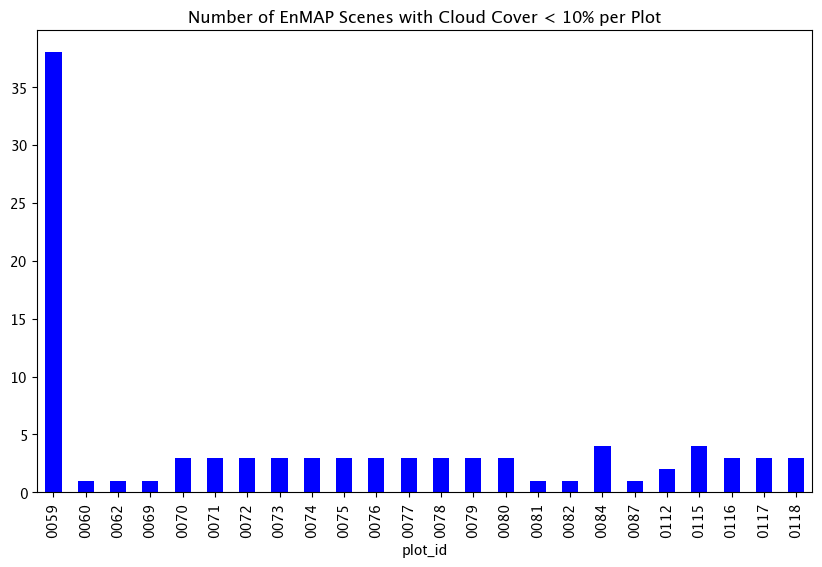

In [31]:
low_cloud_summary_df = df_summary[df_summary.cloud_cover < 10]

low_cloud_summary_df.plot_id.value_counts().sort_index().plot(kind='bar', figsize=(10, 6), color='blue')
plt.title("Number of EnMAP Scenes with Cloud Cover < 10% per Plot")

In [35]:
df_summary.href.iloc[5]

'https://download.geoservice.dlr.de/ENMAP/files/L2A/2022/06/28/DT0000001376/16/ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010400_20240107T000826Z-SPECTRAL_IMAGE_COG.TIF'

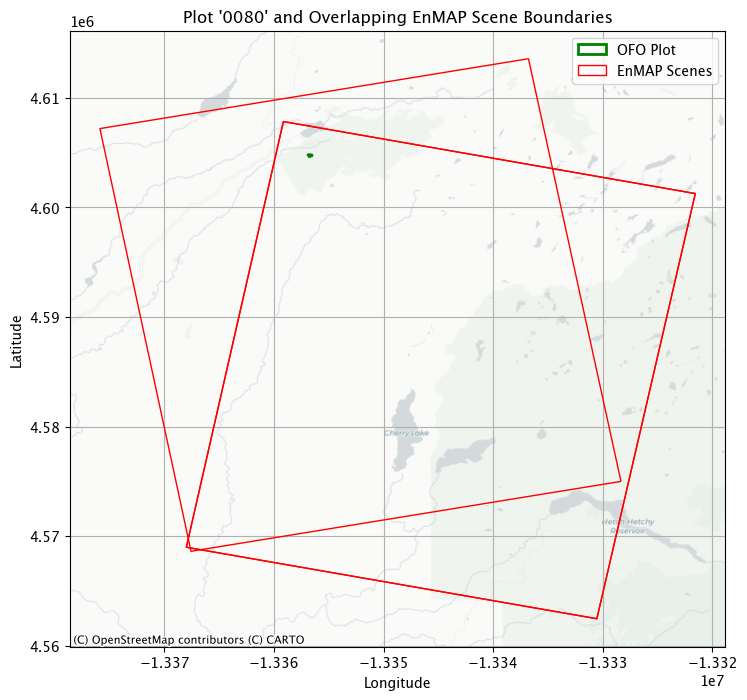

In [36]:
filtered = dl.filter_results_by_properties(ofo_plot_id, {
    "eo:cloud_cover": lambda x: float(x) < 20
})
dl.visualize_plot_and_enmap_bounds(ofo_plot_id, filtered_items=filtered)


In [37]:
filtered

[<Item id=ENMAP01-____L2A-DT0000028166_20230709T064108Z_002_V010402_20240724T202501Z>,
 <Item id=ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010303_20230922T224955Z>,
 <Item id=ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010400_20240107T000826Z>]

In [38]:
# Batch download with cloud cover < 20%, all plots
dl.batch_download(
    plot_ids=["0080"],
    username="dgause",
    password="wT7Ei2zdce!L2kQ",
    filters={"eo:cloud_cover": lambda v: float(v) < 20},
    headless=True,
    overwrite=False,  # skip already-downloaded
    # max_per_plot=4
)


📁 All files will be saved under: ./downloads/enmap_downloads_20250611

📦 Processing plot: 0080
🔍 Filtered to 3 item(s) after applying filters
⬇️ Downloading 0080_ENMAP01-____L2A-DT0000028166_20230709T064108Z_002_V010402_20240724T202501Z_image.tif...
✅ Download complete: ./downloads/enmap_downloads_20250611/0080/0080_ENMAP01-____L2A-DT0000028166_20230709T064108Z_002_V010402_20240724T202501Z_image.tif
✅ Selenium driver closed.
⬇️ Downloading 0080_ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010303_20230922T224955Z_image.tif...
✅ Download complete: ./downloads/enmap_downloads_20250611/0080/0080_ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010303_20230922T224955Z_image.tif
✅ Selenium driver closed.
⬇️ Downloading 0080_ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010400_20240107T000826Z_image.tif...
✅ Download complete: ./downloads/enmap_downloads_20250611/0080/0080_ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010400_20240107T000826Z_image.tif
✅ Selenium driver close

In [45]:
# Batch download with cloud cover < 20%, all plots
dl.batch_download(
    plot_ids=["0070"],
    username="dgause",
    password="wT7Ei2zdce!L2kQ",
    filters={"eo:cloud_cover": lambda v: float(v) < 20},
    headless=True,
    overwrite=False,  # skip already-downloaded
    # max_per_plot=4
)


📁 All files will be saved under: ./downloads/enmap_downloads_20250611

📦 Processing plot: 0070
🔍 Filtered to 3 item(s) after applying filters
⬇️ Downloading 0070_ENMAP01-____L2A-DT0000028166_20230709T064108Z_002_V010402_20240724T202501Z_image.tif...
✅ Download complete: ./downloads/enmap_downloads_20250611/0070/0070_ENMAP01-____L2A-DT0000028166_20230709T064108Z_002_V010402_20240724T202501Z_image.tif
✅ Selenium driver closed.
⬇️ Downloading 0070_ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010303_20230922T224955Z_image.tif...
✅ Download complete: ./downloads/enmap_downloads_20250611/0070/0070_ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010303_20230922T224955Z_image.tif
✅ Selenium driver closed.
⬇️ Downloading 0070_ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010400_20240107T000826Z_image.tif...
✅ Download complete: ./downloads/enmap_downloads_20250611/0070/0070_ENMAP01-____L2A-DT0000001376_20220628T192312Z_016_V010400_20240107T000826Z_image.tif
✅ Selenium driver close

In [39]:
import rioxarray as rxr

# Load hyperspectral image (COG GeoTIFF)
img_path = "./downloads/enmap_downloads_20250611/0080/ENMAP01-____L2A-DT0000028166_20230709T064108Z_002_V010402_20240724T202501Z-SPECTRAL_IMAGE_COG.tiff"
da = rxr.open_rasterio(img_path, masked=True)  # shape: (bands, y, x)


In [43]:
ofo_plot_id = "0059"

df_summary = dl.summarize_metadata([ofo_plot_id])
df_summary


,plot_id,plot_datetime,item_id,hsi_datetime,cloud_cover,tileID,href
0,0059,20200715.0,ENMAP01-____L2A-DT0000134191_20250605T194133Z_...,2025-06-05T19:41:33Z,0,02,https://download.geoservice.dlr.de/ENMAP/files...
1,0059,20200715.0,ENMAP01-____L2A-DT0000132812_20250528T193423Z_...,2025-05-28T19:34:23Z,0,02,https://download.geoservice.dlr.de/ENMAP/files...
2,0059,20200715.0,ENMAP01-____L2A-DT0000132026_20250524T193045Z_...,2025-05-24T19:30:45Z,0,02,https://download.geoservice.dlr.de/ENMAP/files...
3,0059,20200715.0,ENMAP01-____L2A-DT0000129081_20250509T194106Z_...,2025-05-09T19:41:06Z,0,02,https://download.geoservice.dlr.de/ENMAP/files...
4,0059,20200715.0,ENMAP01-____L2A-DT0000128286_20250505T193722Z_...,2025-05-05T19:37:22Z,49,02,https://download.geoservice.dlr.de/ENMAP/files...
5,0059,20200715.0,ENMAP01-____L2A-DT0000127781_20250501T193338Z_...,2025-05-01T19:33:38Z,0,02,https://download.geoservice.dlr.de/ENMAP/files...
6,0059,20200715.0,ENMAP01-____L2A-DT0000124023_20250412T194111Z_...,2025-04-12T19:41:11Z,0,02,https://download.geoservice.dlr.de/ENMAP/files...
7,0059,20200715.0,ENMAP01-____L2A-DT0000123558_20250408T193740Z_...,2025-04-08T19:37:40Z,0,02,https://download.geoservice.dlr.de/ENMAP/files...
8,0059,20200715.0,ENMAP01-____L2A-DT0000122216_20250331T193030Z_...,2025-03-31T19:30:30Z,62,02,https://download.geoservice.dlr.de/ENMAP/files...
9,0059,20200715.0,ENMAP01-____L2A-DT0000118745_20250312T193708Z_...,2025-03-12T19:37:08Z,100,02,https://download.geoservice.dlr.de/ENMAP/files...


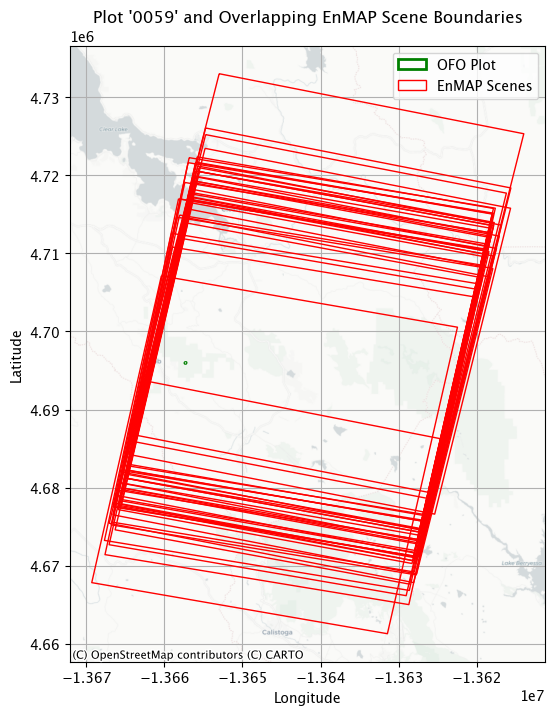

In [44]:
filtered = dl.filter_results_by_properties(ofo_plot_id, {
    "eo:cloud_cover": lambda x: float(x) < 20
})
dl.visualize_plot_and_enmap_bounds(ofo_plot_id, filtered_items=filtered)


In [ ]:
dl.visualize_plot_and_enmap_bounds(ofo_plot_id, filtered_items=filtered)